In [60]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


In [61]:
importpath = r'C:\Users\nmur1\Google Drive\Springboard\Capstone2\CleanData'
os.chdir(importpath)

#import datasets from cleaning
quant = 'Historical Quant Prices.csv'
df = pd.read_csv(quant).drop(columns = 'Unnamed: 0')


Run Binary and Multi Classifications

In [62]:
#classify column 'D'
#Column D measures the 7 day future price change for a given company
#-1 if change is less than 1%, +1 if change is greater than 1%, 0 otherwise
def classifier_binary(x):
    if x < 0:
        return 0
    else:
        return 1
  

def classifier_multi(x):
    if x < -.01:
        return -1
    elif x > .01:
        return 1
    else:
        return 0


df['Dir_Binary'] = df['D'].apply(classifier_binary)
df['Dir_Multi']  = df['D'].apply(classifier_multi)
#df = df.drop(columns = ['D', 'Direction'])



In [63]:
#establish outlier filtered data frames for testing
nooutliers = df[(df.PE_Ratio > df.Lower) & (df.PE_Ratio < df.Upper)]
nooutliers2 = nooutliers[(nooutliers.Sales_Ratio > nooutliers.LowerSR) & (nooutliers.Sales_Ratio < nooutliers.UpperSR)]
nooutliers3 = df[(df.Sales_Ratio > df.LowerSR) & (df.Sales_Ratio < df.UpperSR)]

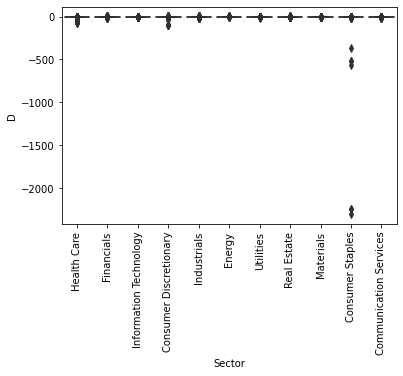

<Figure size 3600x1440 with 0 Axes>

In [64]:
box1 = nooutliers

ax = sns.boxplot(y='D', x='Sector', 
                 data=box1, 
                 palette="colorblind")

plt.setp(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(50,20))
plt.show()

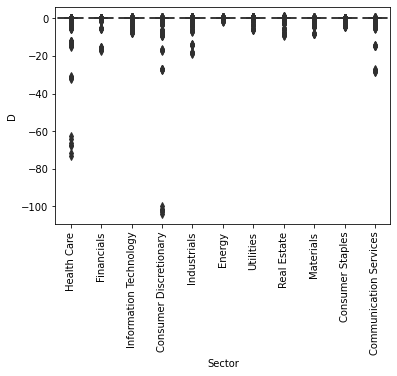

<Figure size 3600x1440 with 0 Axes>

In [65]:
box1 = nooutliers3

ax = sns.boxplot(y='D', x='Sector', 
                 data=box1, 
                 palette="colorblind")

plt.setp(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(50,20))
plt.show()

In [66]:
print(df.shape)
print(nooutliers.shape)
print(nooutliers2.shape)
print(nooutliers3.shape)

(566638, 37)
(382682, 37)
(190261, 37)
(255044, 37)


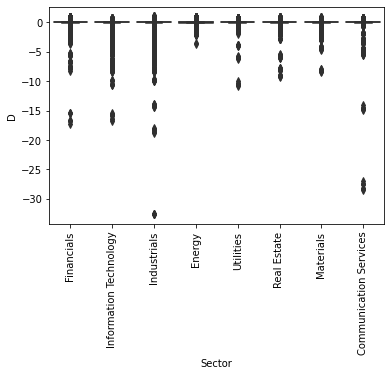

<Figure size 3600x1440 with 0 Axes>

(387581, 37)


In [67]:
box1 = df[(df.Sector != 'Consumer Staples') & (df.Sector != 'Consumer Discretionary') & 
          (df.Sector != 'Health Care')]

ax = sns.boxplot(y='D', x='Sector', 
                 data=box1, 
                 palette="colorblind")

plt.setp(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(50,20))
plt.show()
print(box1.shape)

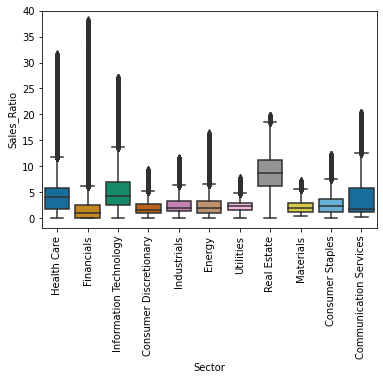

<Figure size 3600x1440 with 0 Axes>

In [68]:

ax = sns.boxplot(y='Sales_Ratio', x='Sector', 
                 data=df, 
                 palette="colorblind")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.figure(figsize=(50,20))
plt.show()

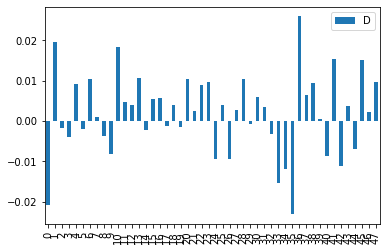

In [69]:
average_returns = df.groupby(['Year','month'])['D'].mean().reset_index()
average_returns['M_Y'] = average_returns[['Year','month']].astype(str).apply(lambda x: '_'.join(x), axis=1)
avg = average_returns[average_returns.Year != 2019]
avg[['D', 'M_Y']].plot(kind = 'bar')

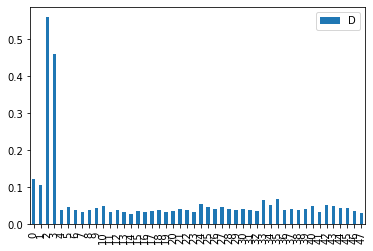

In [70]:
average_returns = df.groupby(['Year','month'])['D'].std().reset_index()
average_returns['M_Y'] = average_returns[['Year','month']].astype(str).apply(lambda x: '_'.join(x), axis=1)
avg = average_returns[average_returns.Year != 2019]
avg[['D', 'M_Y']].plot(kind = 'bar')

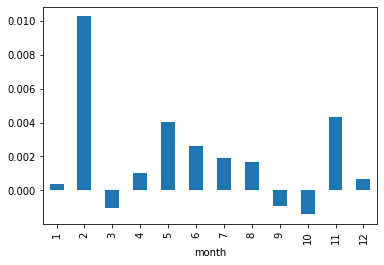

In [71]:
#analyze after chagnes by month
# July and August appear to be highly volatile - I may drop these from my model later

average_monthly =df[df.Year != 2019]
average_monthly = average_monthly[['month', 'D']].groupby('month')['D'].mean()

average_monthly.plot(kind = 'bar')


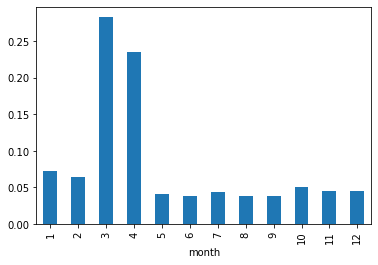

In [72]:

average_monthly =df[df.Year != 2019]
average_monthly = average_monthly[['month', 'D']].groupby('month')['D'].std()

average_monthly.plot(kind = 'bar')


In [73]:
df_Sales = nooutliers3
df_PE = nooutliers


In [74]:
def DropYear(d):
    d['Y_M'] = d[['Year','month']].astype(str).apply(lambda x: '_'.join(x), axis=1)
    df_Month = d[(d.Y_M != '2019_7') & (d.Y_M != '2019_8')]
    df_Month = df_Month.drop(columns = ['Y_M'])
    return df_Month

In [75]:
df_Sales2 = DropYear(df_Sales)
df_PE2 = DropYear(df_PE)
df_Sales.drop(columns = ['Y_M'], inplace = True)
df_PE.drop(columns = ['Y_M'], inplace = True)

C:\Users\nmur1\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nmur1\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Select dataset for moedling

In [76]:
df = df.drop(columns = ['D'])

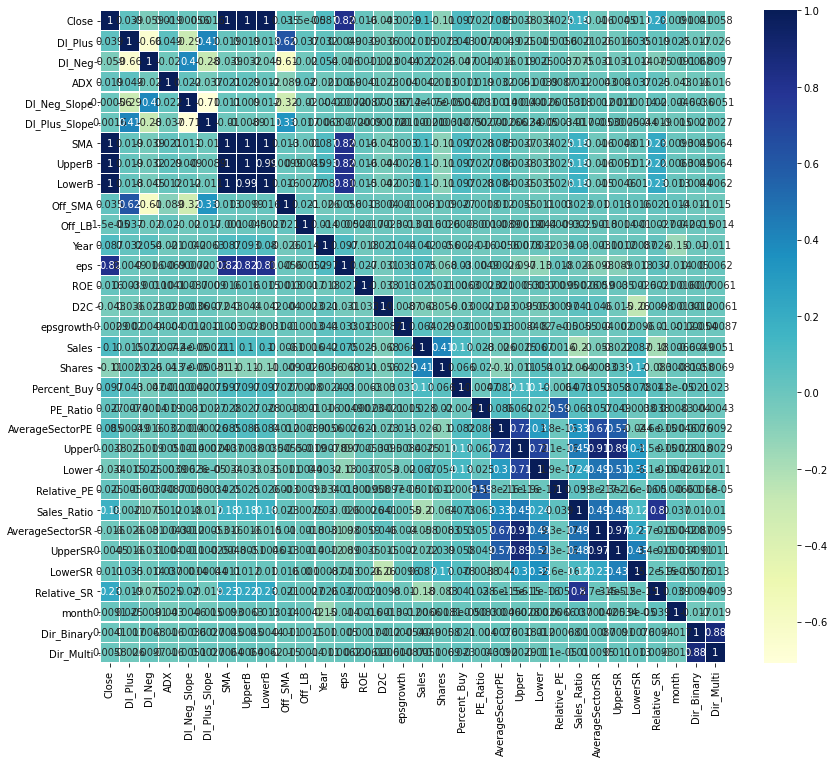

In [77]:
#let's explore correlation and furrther refine the features
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

## Remove Unneccessary Features

* Remove the folling features prior to modeling: close, DI_Plus, DI_Neg, SMA, UpperB, LowerB
* These are fixed whole numbers that are irrelvant by themselves for example I'll be using
    * the 7 day percent change in close price not the close price itself
    * the 7 day running slope of DI_Plus and DI_Neg, not the values themselves
    * the stocks percentage variance from SMA, UpperB, and Lower B, not the values themselves
    
* you'll also note in the correlation heatmap that some of these vairables are correlated with each other. Want to remove these to avoid multicoliniearity

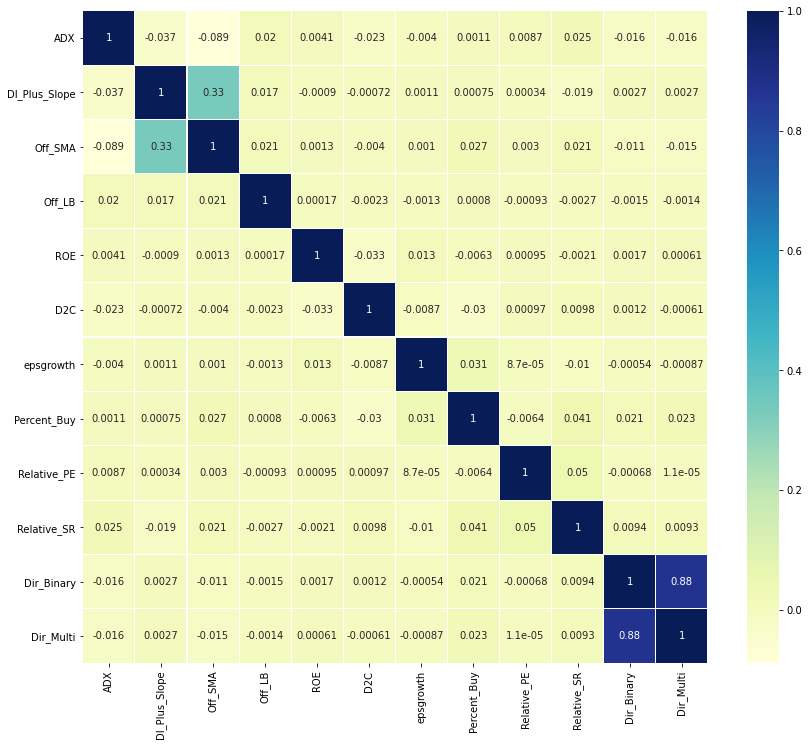

In [78]:
#after dropping some of the noise I'm in a better spot
todrop =  ['AverageSectorSR','Year', 'Sales_Ratio','DI_Neg_Slope','eps','LowerB', 'UpperSR', 'LowerSR','month',
                         'Sales','Shares','UpperB', 'DI_Plus', 'DI_Neg',  'Close', 'SMA', 'AverageSectorPE', 'PE_Ratio', 'Upper', 'Lower']



df2 = df.drop(columns = todrop)

plt.figure(figsize=(14,12))
sns.heatmap(df2.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [79]:
#create dummy variable for the sector
def dummy(df, drop):

    df2 = df.drop(columns = drop)
    ds = pd.get_dummies(df[drop])
    dfdum = pd.concat([df2, ds], axis = 1)

    return dfdum

df2 = dummy(df2, ['Sector'])

In [80]:
#set up X and y varialbes - my final set will also remove the 'Date' and 'Ticker' fields. 
#df2 = df2[df2.Direction !=0]
y = df2['Dir_Binary'].ravel()
X = df2.drop(columns = ['Date','Ticker', 'Dir_Binary','Dir_Multi' ,'Key'])

ym = df2['Dir_Multi'].ravel()
Xm = df2.drop(columns = ['Date','Ticker', 'Dir_Multi', 'Key', 'Dir_Binary'])

In [81]:
#run lasso regression to assess feature selection

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

clf = LassoCV().fit(X, y)

In [82]:
importance = np.abs(clf.coef_)
feature_dict = dict(zip(X.columns, importance))
results = pd.DataFrame.from_dict(feature_dict, orient = 'index', columns = ['Value'])
categorical_variables = ['Sector']

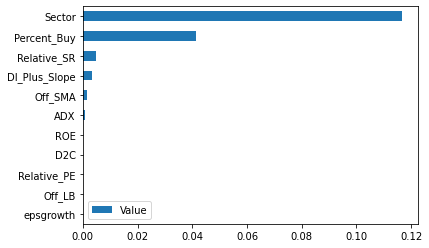

In [83]:
def graph_feature_importances(features, feature_names, autoscale = True, headroom = .05, width = 10, summarized_columns = None):
    if autoscale:
        x_scale = features.max() + headroom
    else:
        x_scale = 1
        
    #feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            
            for i in keys_to_remove:
                feature_dict.pop(i)
            
            feature_dict[col_name] = sum_value
            
    results = pd.DataFrame.from_dict(feature_dict, orient = 'index', columns = ['Value'])
    results.sort_values(by = 'Value', inplace = True)
    results.plot(kind = 'barh')
    
    
graph_feature_importances(results, X.columns, summarized_columns = categorical_variables)

# Analyze Accuracy Scores across different classifier models

In [84]:
# Load Library
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


# Step2: Split the training test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 3: Fit a Decision Tree model as comparison
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print('decision tree:', accuracy_score(y_test, y_pred))

# Step 4: Fit a Random Forest model, " compared to "Decision Tree model, accuracy go up by 5%
RF = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
print('random forest:', accuracy_score(y_test, y_pred))

# Step 5: Fit a AdaBoost model, " compared to "Decision Tree model, accuracy go up by 10%
ADA = AdaBoostClassifier(n_estimators=100)
ADA.fit(X_train, y_train)
y_pred = ADA.predict(X_test)
print('Ada Boost:', accuracy_score(y_test, y_pred))

# Step 6: Fit a Gradient Boosting model, " compared to "Decision Tree model, accuracy go up by 10%
GB = GradientBoostingClassifier(n_estimators=100)
GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)
print('Gradient Boosting:', accuracy_score(y_test, y_pred))


decision tree: 0.6969769165607793
random forest: 0.8020965692503177
Ada Boost: 0.5640794860934633
Gradient Boosting: 0.5667354934349852


# Random Forecst Returning the best accuracy
### Run a few different scenarios with different feature selections

In [85]:
drop1 = ['D2C', 'epsgrowth', 'ROE', 'Off_LB']
drop2 = ['Relative_PE']
drop3 = ['D2C', 'epsgrowth', 'ROE', 'Off_LB', 'DI_Plus_Slope']
drop4 = ['Relative_SR']

In [86]:


X1 = X.drop(columns = drop1)
y1 = df2['Dir_Binary']

X2 = X.drop(columns = drop2)
y2 = df2['Dir_Binary']

X3 = X.drop(columns = drop3)
y3 = df2['Dir_Binary']

X4 = X.drop(columns = drop4)
y4 = df2['Dir_Binary']

#Remove months 7 and 8 
#X3 = X[(X.month != 7) & (X.month != 8)]
#y3 = df2[(df2.month != 7) & (df2.month != 8)]['Direction']
#X3 = X3.drop(columns = drop3)

#remove quarters
#X4 = X[(X.month != 1) & (X.month != 4) & (X.month != 7) & (X.month != 9)]
#y4 = df2[(df2.month != 1) & (df2.month != 4)& (df2.month != 7)& (df2.month != 9)]['Direction']
#X4 = X4.drop(columns = drop3)

dflist =[[X,y],[X1,y1], [X2,y2], [X3,y3], [X4,y4]]

In [87]:
scores = {}
n = 0
for Xa, ya in dflist:

   
    X_train, X_test, y_train, y_test = train_test_split(Xa, ya, test_size = .25, random_state = 42)
    model = RandomForestClassifier(100, n_jobs = -1, random_state = 42, criterion = "gini")
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    ROC = round(roc_auc_score(y_test, ypred),3)
    Accuracy = round(accuracy_score(y_test,ypred),3)
    Recall = round(recall_score(y_test, ypred),3)
    Precision = round(precision_score(y_test, ypred),3)
    F1 = round(f1_score(y_test, ypred),3)
    
    
    scores[n] = [ROC,Accuracy, Recall, Precision, F1]
    #print(scores)
    n = n + 1
    
    

In [88]:
pd.DataFrame(scores, index = ['ROC', 'Accruacy', 'Recall', 'Precision', 'F1'])

# Scenario 0 adds the Relative Price/Sales Ratio which improved my original run accross the board
# Scenario 4 is all features except Price/Sales Ratio

,0,1,2,3,4
ROC,0.788,0.759,0.763,0.786,0.764
Accruacy,0.795,0.769,0.772,0.793,0.773
Recall,0.849,0.841,0.834,0.847,0.836
Precision,0.798,0.768,0.775,0.796,0.776
F1,0.823,0.803,0.803,0.821,0.805


# The highest scores are my on my original feature data set. I'll stick with those

# Run analysis on varying min_samples_leaf

In [89]:
scores = {}


for n in np.arange(1,6,1):

   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)
    model = RandomForestClassifier(50, n_jobs = -1, random_state = 42, min_samples_leaf = n)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    ROC = round(roc_auc_score(y_test, ypred),3)
    Accuracy = round(accuracy_score(y_test,ypred),3)
    Recall = round(recall_score(y_test, ypred),3)
    Precision = round(precision_score(y_test, ypred),3)
    F1 = round(f1_score(y_test, ypred),3)
    
    
    scores[n] = [ROC,Accuracy, Recall, Precision, F1]
    #print(scores)
    n = n + 1
    

Min 1 LEaf socring the best

In [90]:
pd.DataFrame(scores, index = ['ROC', 'Accruacy', 'Recall', 'Precision', 'F1'])

,1,2,3,4,5
ROC,0.783,0.767,0.755,0.743,0.733
Accruacy,0.789,0.777,0.766,0.756,0.747
Recall,0.837,0.847,0.848,0.848,0.848
Precision,0.797,0.775,0.762,0.749,0.739
F1,0.816,0.810,0.803,0.795,0.790


Analyze Scenarios where Outlying Sales/Price Ratios are removed, Outlying Price to Earnings, and high volatility months 7 and 8 in year 2019

In [91]:
todrop =  ['AverageSectorSR','Year', 'Sales_Ratio','DI_Neg_Slope','eps','LowerB', 'UpperSR', 'LowerSR','month',
                         'Sales','Shares','UpperB', 'DI_Plus', 'DI_Neg',  'Close', 'SMA', 'AverageSectorPE', 
                        'D','PE_Ratio', 'Upper', 'Lower']

df_Sales = dummy(df_Sales, ['Sector'])
df_Sales2 = dummy(df_Sales2, ['Sector'])
dfSales3 = df_Sales[df_Sales.eps > 0]
df_PE = dummy(df_PE, ['Sector'])
df_PE2 = dummy(df_PE2, ['Sector'])


In [92]:


dflist = [df_Sales, dfSales3, df_Sales2, df_PE,df_PE2]
scores = {}
n = 0

for df in dflist:
   

    df2 = df.drop(columns = todrop)
    Xa = df2.drop(columns = ['Date','Ticker', 'Dir_Binary','Dir_Multi' ,'Key'])
    ya = df2['Dir_Binary']
    model = RandomForestClassifier(100, n_jobs = -1, random_state = 42, min_samples_leaf = 1, criterion = "gini")
    X_train, X_test, y_train, y_test = train_test_split(Xa, ya, test_size = .25, random_state = 42)
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    ROC = round(roc_auc_score(y_test, ypred),3)
    Accuracy = round(accuracy_score(y_test,ypred),3)
    Recall = round(recall_score(y_test, ypred),3)
    Precision = round(precision_score(y_test, ypred),3)
    F1 = round(f1_score(y_test, ypred),3)
    
    
    scores[n] = [ROC,Accuracy, Recall, Precision, F1]
    #print(scores)
    n = n + 1
    print(Accuracy)

pd.DataFrame(scores, index = ['ROC', 'Accruacy', 'Recall', 'Precision', 'F1'])

0.799
0.803
0.804
0.799
0.801


,0,1,2,3,4
ROC,0.791,0.795,0.796,0.792,0.793
Accruacy,0.799,0.803,0.804,0.799,0.801
Recall,0.853,0.857,0.859,0.854,0.853
Precision,0.802,0.806,0.805,0.803,0.804
F1,0.827,0.830,0.831,0.827,0.828


# Run Final Accruacy scores, graph feature importance, review confusion matrix for chosen model

In [93]:
finalDF = dfSales3

finalDF = finalDF.drop(columns = todrop)

#export final dataset to use in live model
finalDF.to_csv('Final_Final_Model_Set.csv')
X = finalDF.drop(columns = ['Date','Ticker', 'Dir_Binary','Dir_Multi' ,'Key'])
y = finalDF['Dir_Binary']



In [94]:
model = RandomForestClassifier(100, n_jobs = -1, random_state = 42, min_samples_leaf = 1, criterion = "gini")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

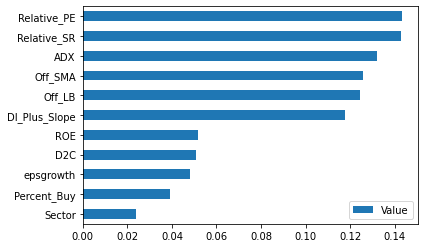

In [95]:
def graph_feature_importances(model, feature_names, autoscale = True, headroom = .05, width = 10, summarized_columns = None):
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
        
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            
            for i in keys_to_remove:
                feature_dict.pop(i)
            
            feature_dict[col_name] = sum_value
            
    results = pd.DataFrame.from_dict(feature_dict, orient = 'index', columns = ['Value'])
    results.sort_values(by = 'Value', inplace = True)
    results.plot(kind = 'barh')
    
    
graph_feature_importances(model, X.columns, summarized_columns = ['Sector'])

In [96]:
from sklearn.metrics import confusion_matrix
false_positives = confusion_matrix(y_test, ypred)[0][1]
print('False Positives in Test:', false_positives)
print("Chance of FP's ", round(false_positives / len(y_test),4) * 100)

False Positives in Test: 6957
Chance of FP's  11.64


ROC: 0.795
Accuracy 0.803
Recall 0.857
Precision 0.806
F1 0.83


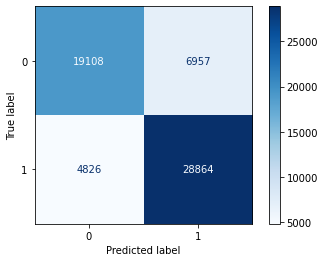

In [97]:
print('ROC:', round(roc_auc_score(y_test, ypred),3))
print('Accuracy', round(accuracy_score(y_test,ypred),3))
print('Recall', round(recall_score(y_test, ypred),3))
print('Precision', round(precision_score(y_test, ypred),3))
print('F1', round(f1_score(y_test, ypred),3))

pd.reset_option('display.float_format')
confmat = plot_confusion_matrix(model, X_test, y_test, cmap="Blues",values_format='.0f')

For this project I want to focus on maximizing Precision - minimizing false positive classifications
A false positive would trigger a buy on a stock that will go down causing an actual loss. A false negative would mean I don't buy a stock that is actually going to go up; there would be opportunity cost but not an actual monetary loss.

* Recall = True Positive / (True Positive + False Negative)
* Precision = True Positive / (True Positive + False Positive)
* F1 = (2 x Precision x Recall) / (Precision + Recall)

### Run model using a multi classifier where -1 = less than 1% drop in price, +1 = more than 1% drop in price, 0 = between -1 and 1% change

In [98]:
model = RandomForestClassifier(100, n_jobs = -1, random_state = 42, min_samples_leaf = 1, criterion = "gini")
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size = .25, random_state = 42)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

In [99]:
#print('ROC:', round(roc_auc_score(y_test, ypred),3))
print('Accuracy', round(accuracy_score(y_test,ypred),3))
print('Recall', round(recall_score(y_test, ypred, average = 'weighted'),3))
print('Precision', round(precision_score(y_test, ypred, average = 'weighted'),3))
print('F1', round(f1_score(y_test, ypred,average = 'weighted'),3))

Accuracy 0.697
Recall 0.697
Precision 0.685
F1 0.686
